## Introduction

The goal of this notebook is to introduce you the end-to-end process involved in a Image Classification project. We will be working on the Kannada version of <a href="https://www.kaggle.com/c/digit-recognizer/">MNIST</a> data unlike using the Arabic Numerals. 

Kannada is a language spoken predominantly by people of Karnataka in southwestern India. The language has roughly 45 million native speakers and is written using the Kannada script.

I will be answering the following questions through code in this kernel:
- How to  define the objective?
- How to understand our data?
- How to prepare the data?
- How to work with simple models?
- What are convolutions?
- How to build one?
- How to evaluate our model?
- Why you need to give an upvote for this kernel?

==> If you want to travel along please fork this notebook and execute the cells when needed.

## Understanding the objective

Let us take some time to understand what we are trying to achieve in this project. Most of the Machine Learning projects fail just because of not setting a clear objective. Always remember, 
> One who knows where to go, is the one who moves ahead

In our case, our objective is to build a classification model which inputs an image of handwritten kannada digit and outputs the predicted number in that image.

**Evaluation Metric:** Accuracy 

**Metric Definition:** The percentage of correct prediction (Total correct predictions / Total samples)

## Understanding our data
In our scenario the data is readily available but that is not the case for all the Machine Learning projects. You need to typically gather relevant data from multiple sources. If needed you might want to generate your data as well.

In [ ]:
# Importing the required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import os
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Discovering the files available
path = "../input/Kannada-MNIST/"
os.listdir(path)

In [ ]:
# Importing the data
train = pd.read_csv(path+"train.csv")
test = pd.read_csv(path+"test.csv")
submission = pd.read_csv(path+"sample_submission.csv")

In [ ]:
# Check the shape of our data
train.shape, test.shape

The data contains 785 columns, one for each pixel and a label column (ground-truth) for every data point. To make things simple each data point contains information about 28 x 28 pixel image + a label column.

In [ ]:
# Check the data samples
train.head(3)

In [ ]:
# Check for any missing values
train.isnull().sum().sum(), test.isnull().sum().sum()

Look's like there are no missing values in the dataset. Hurray!

In [ ]:
# Let us understand our target variable's distribution
sns.countplot(train["label"])
plt.show()

This is a balanced dataset, which means that we have an equal number of data samples for all the target classes. But in the case of an unbalanced dataset, we must handle that with the help of different sampling techniques as it could affect the model's performance.

For visualizing the image we need to convert it into a 3 dimensional data where the third dimension denotes the color channel. 1 - Grayscale, 3 - RGB 

In [ ]:
# Looking at individual samples
def visualize_image(ix=0):
    plt.imshow(train.iloc[ix, 1:].values.reshape(28, 28, 1)[:, :, 0])
    plt.title("Class = " + str(train["label"].loc[ix]))
    plt.show()

visualize_image(1)

## Method 1: Simple Classifiers
We will build some simple classifiers using linear and tree based models and then I will let you know why we need to go for convolutions than sticking with simple models.

In [ ]:
# Setting the seed
seed = 10

In [ ]:
# Splitting target and features
target = train["label"]
features = train.drop("label", 1)

Let us reduce the dimension from 784 to 2 so that we can visualize our data better.

In [ ]:
from sklearn.decomposition import PCA
from umap import UMAP

pca = PCA(random_state=seed, n_components=50)
%time pca_features = pca.fit_transform(features)

umap = UMAP(n_neighbors=10, metric="cosine", random_state=seed, n_epochs=300)
%time umap_features = umap.fit_transform(pca_features)

In [ ]:
plt.figure(figsize=(10, 7))
sns.scatterplot(umap_features[:, 0], umap_features[:, 1], hue=target, palette=sns.color_palette("Set1", target.nunique()))
plt.show()

In [ ]:
# Splitting the data into train, val and test sets

x, x_val, y, y_val = train_test_split(umap_features, target, random_state=seed, stratify=target, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=seed, stratify=y, test_size=0.2)

In [ ]:
# Defining the classifiers
classifiers = {"LR": LogisticRegression(random_state=seed), "RF": RandomForestClassifier(random_state=seed), "KNN": KNeighborsClassifier(n_neighbors=20, n_jobs=-1)}

In [ ]:
# Building the models
models = {}
val_preds = {}
test_preds = {}
for k, v in classifiers.items():
    print(f"{k}")
    %time models[k] = v.fit(x_train, y_train)
    val_preds[k] = models[k].predict(x_val)
    test_preds[k] = models[k].predict(x_test)
    print(f"Validation Accuracy: {np.round(models[k].score(x_val, y_val), 4)} | Test Accuracy: {np.round(models[k].score(x_test, y_test), 4)}")

Looks like KNN classifier fits our data much better when compared to others.

In [ ]:
# Analyzing the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, test_preds["KNN"]), annot=True, fmt='d')
plt.show()

From the confusion matrix above we can infer that our model is finding it hard to classify classes 0, 6, 7 and 9. This might be due to noise or poor feature selection.

In [ ]:
# Plotting the decision boundary
from mlxtend.plotting import plot_decision_regions

plt.figure(figsize=(10, 7))
plot_decision_regions(x_test, y_test.values, clf=models["KNN"])
plt.show()

## Method 2: Convolutional Neural Network (CNN)

For machines an image is an array of pixels stacked as X dimension x Y dimension x No.of channels. Example: 32x32x1 (1 - grayscale, 3 - RGB). If we are working with a 28 x 28 pixels then we would have 784 columns of information about the image. Consider the same for a 1024 x 1024 size image. As the image quality increases the number of dimensions as well. It would be difficult to always use dimensionaltiy reduction techniques to handle huge dimensions as there is a greater chance of loosing valuable information and also when dealing with the fully connected neural network the number of nodes increases depending on the number of neurons in each layer. And that's where CNN comes into play. Also another reason why we move to CNNs are because they learn on their own and requires less feature engineering when compared to traditional classifiers.

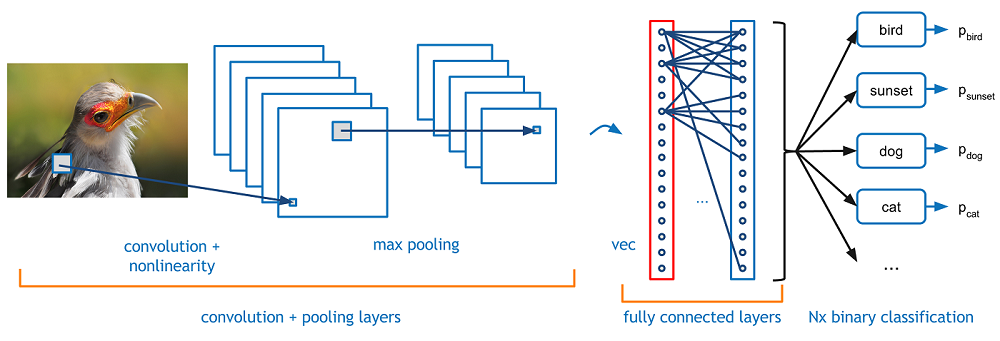

CNN consists of **convolution** and **pooling** layers stacked on top of a fully connected neural network. CNN basically reduces the dimensions by retaining only the key features in the image by performing convolution and pooling.

**Important:** For a detailed explanation of CNN I would engourge you to read <a href="https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53">this</a> blog by Sumit Saha. This clearly explains how CNNs work. After reading the blog don't forget to revisit this kernel for the practical application of the techniques learnt.

We will be using the Keras API in Tensorflow to create a CNN model. You can also create the same with the help of core TensorFlow, PyTorch and other deep learning libraries as well. Without any further talk let us jump right into the code.

In [ ]:
# Scaling the pixel values to a range between 0 and 1
X = features / 255
payload = test.drop("id", 1) / 255

In [ ]:
# Reshaping the data into a 3 dimensional array
X = X.values.reshape(-1, 28, 28, 1)
payload = payload.values.reshape(-1, 28, 28, 1)

# Encoding the target variable. This is because we will be using softmax in the output layer and it outputs probabilities for each class
Y = tf.keras.utils.to_categorical(target, num_classes = 10)

In [ ]:
# Splitting the data into train, val and test sets

x, x_val, y, y_val = train_test_split(X, target, random_state=seed, stratify=target, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=seed, stratify=y, test_size=0.2)

In [ ]:
# Data augmentation
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False
)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = tf.nn.relu, input_shape = (28, 28, 1)),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation = tf.nn.softmax)
])

In [ ]:
optimizer=tf.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [ ]:
history = model.fit_generator(data_gen.flow(x_train, y_train, batch_size=64), epochs=5, validation_data=(x_test, y_test), verbose=1, steps_per_epoch=x_train.shape[0]//64)

In [ ]:
submission["label"] = np.argmax(model.predict(payload), 1)

In [ ]:
submission.to_csv("submission.csv", index=False)

In [ ]:
submission.head(3)

In [ ]:
plt.imshow(test.iloc[1, 1:].values.reshape(28, 28, 1)[:, :, 0])